In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sparse
import random
import implicit 
import matplotlib.pyplot as plt
import datetime
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k

C:\Users\mi\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
%%time
def preprocess_items(full_list_movies, movies_df=pd.read_csv('movie.csv')):
    '''
    Принимает:
    -список всех фильмов, которые есть в трейне и тесте (full_list_movies)
    -датафрейм фильмов из файла movies.csv (movies_df)
    
    Возвращает:
    -измененный датафрейм из файла movies.csv (movies_df)
    -список фичей фильмов в виде необходимом для lightFM (item_feats)
    -список всех возможных фичей для lightFM (possible_feats)
    
    
    функция предобработки жанров фильмов как фичей,
    каждая фича имеет бинарное представление 0/1
    на выходе получается матрица movieId - features    
    '''
    movies_df = movies_df[movies_df.movieId.isin(full_list_movies)]
    
    list_genres = []
    for i in full_list_movies:
        list_genres += movies_df[movies_df.movieId == i].genres.values[0].split('|')
    
    list_genres = sorted(list(set(list_genres)))
    
    movies_ids = list(movies_df.movieId)
    for genre in list_genres:
        genre_indicator = []
        for i in range(0, len(movies_df)):
            if genre in movies_df.genres.iloc[i]:
                genre_indicator.append(1)
            else:
                genre_indicator.append(0)
            
        movies_df[genre] = genre_indicator
        
        
    movies_df = movies_df.drop(['title', 'genres'], axis=1)
    
    
    indexes = list(movies_df.index)
    len_m = len(movies_df)
    for col in movies_df.drop(['movieId'], axis=1).columns:
        
        movies_df[col] = pd.Series(pd.Series([col] * len_m, index = indexes) + pd.Series([':'] * len_m, index = indexes) + movies_df[col].astype(str))

        
    item_feats = []
    
    for i in range(len_m):
        movie = movies_df.iloc[i].movieId
        item_feats.append(tuple([movie, list(movies_df.iloc[i])[1::] ]))
        
    
    possible_feats = []
    features = list(movies_df.drop(['movieId'], axis=1).columns)
    
    for col in features:
        possible_feats += sorted(list(movies_df[col].unique()))
                   
    return movies_df, item_feats, possible_feats

def tags_item_features(data_train, data_test):
    '''
    Принимает:
    -train и test датафреймы
    
    Возвращает:
    -измененный датафрейм из файла movies.csv (movies_df)
    -список фичей фильмов в виде необходимом для lightFM (item_feats)
    -список всех возможных фичей для lightFM (possible_feats)
    
    
    Функция подгружает все файлы связанные с тегами
    Функция отбирает для каждого фильма ниболее релевантный тег
    Создает для него признак 'tag'
    возвращает df со столбцами [movieId, tag],
    причем столбец tag в виде 'tag':0/1
    item_feats в виде
    [('movieId', [feature_name:feature_value...)]
    ...
    ]

    '''
    
    genome_tags = pd.read_csv('genome_tags.csv')
    tag = pd.read_csv('tag.csv')
    gen_score = pd.read_csv('genome_scores.csv')
    movies_df = pd.read_csv('movie.csv')

    full_list_movies = list_movies_func(data_train, data_test)

    movies_df = movies_df[['movieId']][movies_df.movieId.isin(full_list_movies)]

    movie_tag = gen_score.merge(genome_tags, how='inner', on='tagId').sort_values(by=['movieId']).reset_index(drop=True)
    movie_tag = movie_tag.drop(['tagId'], axis=1)

    movie_tag = movie_tag[movie_tag.movieId.isin(full_list_movies)]

    max_relevance_tags = pd.DataFrame(movie_tag[['movieId','relevance']].groupby(by=['movieId']).agg('max').relevance.index)
    max_relevance_tags['relevance'] = movie_tag[['movieId','relevance']].groupby(by=['movieId']).agg('max').relevance.values
    
    list_movies = movies_df.movieId.unique()
    movie_tag = movie_tag.sort_values(by=['movieId','relevance'], ascending=[True, False]).reset_index(drop=True)
    movie_tag = movie_tag.drop(['relevance'], axis=1)

    movieOneTag = pd.DataFrame(columns=['movieId', 'tag'])
    for movie in movie_tag.movieId.unique():
    
        movieOneTag = pd.concat([movieOneTag, pd.DataFrame([list(movie_tag[movie_tag.movieId == movie].iloc[0].values)], columns=['movieId',  'tag'])] ).reset_index(drop=True)
        
    movies_no_tag = []
    movie_with_tag = list(movieOneTag.movieId)
    for movie in full_list_movies:
        if (movie in movie_with_tag) == False:
            movies_no_tag.append(movie)
        
    movie_no_tag_df = pd.DataFrame(movies_no_tag, columns=['movieId'])
    movie_no_tag_df['tag'] = ['NoTag'] * len(movie_no_tag_df)

    movie_tag = pd.concat([movieOneTag, movie_no_tag_df]).reset_index(drop=True)
    
    movies_df = movies_df.merge(movie_tag, how='inner', on='movieId')
    
    indexes = list(movies_df.index)
    len_m = len(movies_df)
    movies_df['tag'] = pd.Series(pd.Series(['tag'] * len_m, index = indexes) + pd.Series([':'] * len_m, index = indexes) + movies_df['tag'].astype(str))

        
    item_feats = []
    
    for i in range(len_m):
        movie = movies_df.iloc[i].movieId
        item_feats.append(tuple([movie, list(movies_df.iloc[i])[1::] ]))
        
    
    possible_feats = []
    features = list(movies_df.drop(['movieId'], axis=1).columns)
    
    for col in features:
        possible_feats += sorted(list(movies_df[col].unique()))
    
    
    return movies_df, item_feats, possible_feats




def dcg(y_relevance) :
    return np.sum([(2**i - 1) / np.log2(k + 1) for (k, i) in enumerate(y_relevance, start=1)])

def ndcg(y_relevance, k):
    
    if y_relevance.sum() == 0:
        return 0.0
    
    DCG = dcg(y_relevance[:k])
    IDCG = dcg(-np.sort(-y_relevance)[:k])
    return DCG / IDCG


def calc_ndcg(data_test, list_recommends, k=20):
    '''
    Функция подсчета метрики nDCG@K
    На вход подается data_test, представляющий из себя pd.Series,
    где индекс строки соответсвует user_id,
    а values строки-это список просмотренных пользователем фильмов;
    список рекомендация в виде
    [(user_id, [movie_id_0, movie_id_1, movie_id_2, ... movie_id_k] ),
    ....
    ],
    число k для подсчета метрики nDCG@K.
    
    Функция возвращает усредненное по количеству рекомендаций значение метрики 
    '''
    
    full_dcg_list = []
    j = 0
    for user, recom in list_recommends:

        dcg_list = []
        for rec in recom:
            if rec in data_test[user]:
                dcg_list.append(1)
            else:
                dcg_list.append(0)
        full_dcg_list.append(dcg_list)
    
            
    ndcgs_list = []
    for nd in full_dcg_list:
        ndcgs_list.append(ndcg(np.array(nd), k))
    mean_ndcgs = np.mean(ndcgs_list)
    
    return mean_ndcgs

def top_n_movies(model, user_id, data_train, full_list_movies, n=20):
    
    '''
    Принимает:
    -обученную модель lightFM (model),
    -id пользователя, для которого строятся рекомендации (user_id),
    -трейн датафрейм (data_train),
    -список всех фильмов (full_list_movies)
    -количество фильмов для рекомендации (n).
    
    Возвращает:
    -список из топ n фильмов для рекомендации
    
    Строятся рекомендации на всех фильмах, из них отбираются те, что для user_id
    не участвовали в трейне, список сортируется по внутреннему скору модели,
    возвращается list из movie_id, содержащий n фильмов с наибольшим скором.
    
    '''
    
    user_ids = [user_id] * len(full_list_movies)
    movie_ids = np.arange(0, len(full_list_movies))
    movie_recs = pd.DataFrame()
    movie_recs['movieId'] = pd.DataFrame(full_list_movies)
    
    movie_recs['recs'] = model.predict(np.array(user_ids), np.array(movie_ids), num_threads=4)
    
    #movie_recs = movie_recs[movie_recs.movieId.isin(list(data_train[data_train.userId == user_id].movieId)) == False]
    movie_recs = movie_recs.sort_values(by=['recs'], ascending=False)
    
    return list(movie_recs.movieId[0:n])

def list_movies_func(data_train, data_test):
    '''
    Принимает:
    -трейн и тест датафреймы
    
    Возвращает:
    -список всех фильмов из теста и трейна
    
    функция для формирования всех фильмов
    которые рассматриваются в тесте и трейне
    '''
    full_list_movies = sorted(list(set(list(data_train.movieId.unique()) + list(data_test.movieId.unique()))))
    return full_list_movies


def lightfm_ndcg_score(model, data_train, data_test, user_dict, movie_dict, percent_to_test=100, n=20):
    
    '''
    Принимает: 
    -обученную модель
    -трейн и тест датафреймы
    -словари для юзеров и фильмов
    
    
    Возвращает:
    -средние значение метрики
    
    
    считает метрику на percent_to_test процентах
    пользователей
    если percent_to_test < 100, то выбираются случайные пользователи
    
    '''
    
    full_list_movies = list_movies_func(data_train, data_test)
    
    data_test = data_test.sort_values(by=['userId','timestamp'])
    data_test = data_test[['userId', 'movieId']].groupby(by=['userId']).agg(lambda x:list(x))

    data_test = data_test.movieId
    
    list_recommends = []
    
    list_users = list(data_test.index)
    len_users = len(list_users)
    
    list_ndcgs = []
    
    for i in range(0, round((len(data_test) / 100) * percent_to_test)):  
        #юзеров для оценки каждый раз выбираем рандомно
        if percent_to_test < 100:
            new_user = random.randint(0, len_users)
        else:
            new_user = i
            
        
        list_recommends = [tuple([user_dict[new_user], top_n_movies(model, new_user, data_train, full_list_movies, n=n)])]
        
        list_ndcgs.append(calc_ndcg(data_test, list_recommends, k=20))
    
        if (i % (len_users // 10) == 0) and (i > 0):
            print(f'Для {round((i / len_users) * 100)} % пользователей mean nDcg@ =  {np.mean(list_ndcgs)}')
        
    return np.mean(list_ndcgs)

def tags_genres_as_fetures(data_train, data_test):
    full_list_movies = list_movies_func(data_train, data_test)
    movies_df_1 = preprocess_items(full_list_movies)

    movies_df_2 = tags_item_features(data_train, data_test)
    
    full_movie_df = movies_df_2[0].merge(movies_df_1[0], how='inner', on='movieId')
    
    item_feats = []
    len_m = len(full_movie_df) 
    for i in range(len_m):
        movie = full_movie_df.iloc[i].movieId
        item_feats.append(tuple([movie, list(full_movie_df.iloc[i])[1::] ]))
        
    
    possible_feats = []
    features = list(full_movie_df.drop(['movieId'], axis=1).columns)
    
    for col in features:
        possible_feats += sorted(list(full_movie_df[col].unique()))
        
    return full_movie_df, item_feats, possible_feats

def build_dataset_lightfm(data_train, data_test, features='genres'):
    '''
    функция подгружает data_train
     и датасет с фильмами, 
     обрабатывает movie_features и строит даасет для lightfm
     на выходе получаются разреженные матрицы interactions,
     weights и item_features
    '''

    full_list_movies = list_movies_func(data_train, data_test)
    
    if features == 'genres':
        movies_df, item_feats, possible_feats = preprocess_items(full_list_movies)
    elif features == 'tags':
        movies_df, item_feats, possible_feats = tags_item_features(data_train, data_test)
    elif features == 'all':
        movies_df, item_feats, possible_feats = tags_genres_as_fetures(data_train, data_test)
    

    data = Dataset()#item_identity_features=False)
    data.fit(sorted(list(data_train.userId.unique())), sorted(list(movies_df.movieId.unique())),
             item_features=possible_feats)
    interactions_matrix, weights_matrix = data.build_interactions([tuple(i) for i in data_train.drop(['timestamp'], axis = 1).values])
    item_features = data.build_item_features(i for i in item_feats)
    
    return interactions_matrix, weights_matrix, item_features

def user_movies_to_dict(data_train=pd.read_csv('rand_train_30.csv'),
                        data_test=pd.read_csv('rand_test_30.csv')):
    '''
    функция для записи юзеров и пользователей в словарь
    так как в lightfm не учитываются userId и movieId
    '''
    
    
    data_test = data_test.sort_values(by=['userId','timestamp'])
    data_test = data_test[['userId', 'movieId']].groupby(by=['userId']).agg(lambda x:list(x))

    data_test = data_test.movieId
    
    user_dict = {}
    movie_dict = {}
    i = 0
    users = sorted(list(set(data_train['userId'].values)))
    for i in range(len(users)):
        user_dict[i] = users[i]
        i += 1
    
    i = 0
    movies_test = []
    for i in data_test.values:
        movies_test += i
    
    movies = sorted(list(set(list(data_train['movieId'].values) + movies_test)))
    for i in range(len(movies)):
        movie_dict[i] = movies[i]
        i += 1
        
    return user_dict, movie_dict


def grid_search(train, test,
                   item_features,
                   train_weights, test_weights,
                   no_components_list,
                   learning_rate_list,
                   max_sampled_list):
    
    '''
    функция для поиска настройки гиперпараметров
    в качестве метрики здесь используется встроенная функция 
    библиотеки lightfm precision_at_k из предположения
    что максимизация Precision@k влечет за собой максимизацию 
    оценки снизу метрики nDCG@k
    
    Ничего не выводит, печатает  метрику precision@20
    для каждого набора параметров на внутреннем тесте
    '''
    
    for no_comp in no_components_list:

        for le_rate in learning_rate_list:
 
            for max_samp in max_sampled_list:
                model = LightFM(no_components=no_comp,
                    learning_rate=le_rate, 
                    loss='warp',
                    max_sampled=max_samp, random_state=23)
            
                now = datetime.datetime.now()
                print(f'{now.hour}:{now.minute}:{now.second} no_components: {no_comp}, learning_rate: {le_rate}, max_sampled: {max_samp}')
                model.fit(train,
                          sample_weight=train_weights,
                          item_features=item_features,
                          num_threads=4, verbose=True)
                
                print(precision_at_k(model,
                                                  test,
                                                  train,
                                                  k=20,
                                                 item_features=item_features).mean())

                    
    return None

Wall time: 11.2 s


## Жанры фильмов как item_features

In [3]:
%%time
interactions_matrix, weights_matrix, item_features = build_dataset_lightfm(data_train=pd.read_csv('rand_train_30.csv'),
                                                                           data_test=pd.read_csv('rand_test_30.csv'),
                                                                          features='genres')

user_dict, movie_dict = user_movies_to_dict(data_train=pd.read_csv('rand_train_30.csv'),data_test=pd.read_csv('rand_test_30.csv'))

<timed exec>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Wall time: 2min 31s


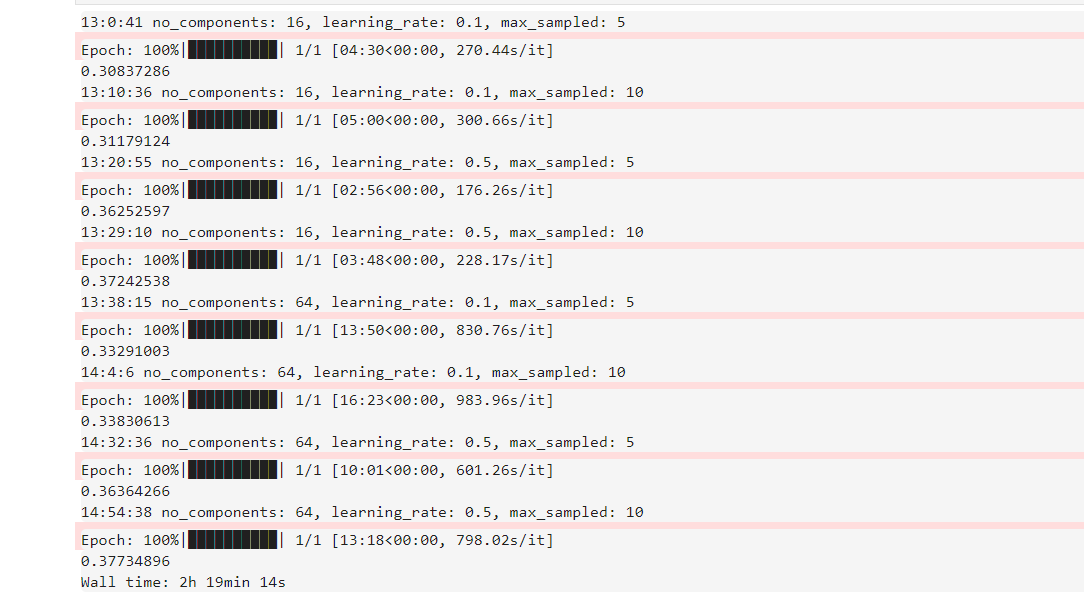

In [4]:
model = LightFM( no_components=64,
                    learning_rate=0.5, 
                    loss='warp',
                    max_sampled=10, random_state=23)

In [5]:
%%time
model.fit(interactions_matrix,
          sample_weight=weights_matrix,
          item_features=item_features,
          epochs=1,
          num_threads=4,verbose=True)

Epoch: 100%|██████████| 1/1 [16:17<00:00, 977.52s/it]

Wall time: 16min 17s


In [9]:
lightfm_ndcg_score(model, data_train=pd.read_csv('rand_train_30.csv'),
                   data_test=pd.read_csv('rand_test_30.csv'), user_dict=user_dict,movie_dict=movie_dict,
                   percent_to_test=100, n=20)

Для 10 % пользователей mean nDcg@ =  0.3438172219594964
Для 20 % пользователей mean nDcg@ =  0.34590888332470243
Для 30 % пользователей mean nDcg@ =  0.3470981905617484
Для 40 % пользователей mean nDcg@ =  0.3465961980030207
Для 50 % пользователей mean nDcg@ =  0.34565830672125647
Для 60 % пользователей mean nDcg@ =  0.34582874337792713
Для 70 % пользователей mean nDcg@ =  0.345970546973324
Для 80 % пользователей mean nDcg@ =  0.34588213645389426
Для 90 % пользователей mean nDcg@ =  0.34576555196821246
Для 100 % пользователей mean nDcg@ =  0.34632081245937535


0.3463210031246274

Метрика nDCG@20 при использованиии только жанров фильмов как item_features на тесте = 0.346

## Теги как item_features

In [10]:
%%time
interactions_matrix, weights_matrix, item_features = build_dataset_lightfm(data_train=pd.read_csv('rand_train_30.csv'),
                                                                           data_test=pd.read_csv('rand_test_30.csv'),
                                                                           features = 'tags' )

# user_dict, movie_dict = user_movies_to_dict(data_train=pd.read_csv('rand_train_30.csv'),
#                                             data_test=pd.read_csv('rand_test_30.csv'))

Wall time: 3min 59s


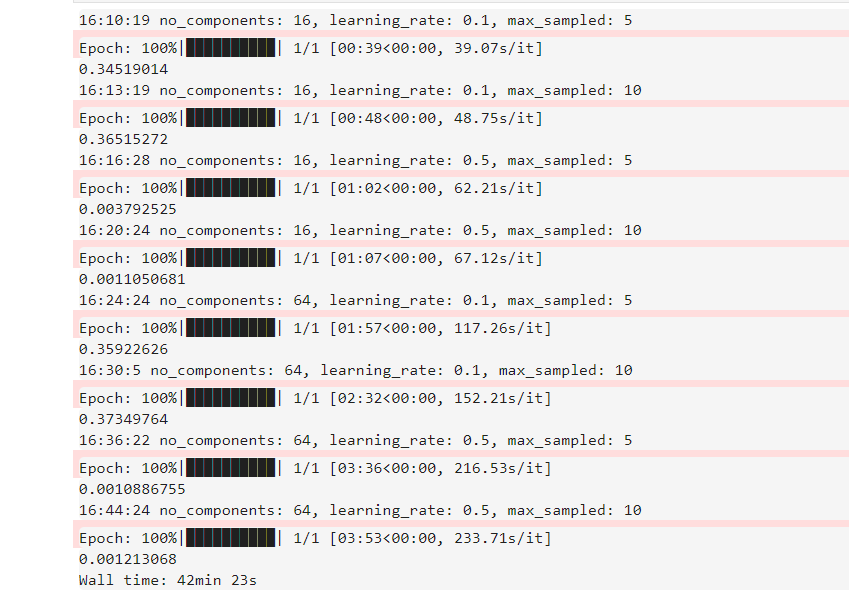

In [13]:
model2 = LightFM(no_components=64,
                    learning_rate=0.1, 
                    loss='warp',
                    max_sampled=10, random_state=23)

In [14]:
%%time
model2.fit(interactions_matrix,
          sample_weight=weights_matrix,
          item_features=item_features,
          epochs=1,
          num_threads=4,verbose=True)

Epoch: 100%|██████████| 1/1 [03:13<00:00, 193.68s/it]

Wall time: 3min 13s


In [15]:
%%time
lightfm_ndcg_score(model2, data_train=pd.read_csv('rand_train_30.csv'),
                   data_test=pd.read_csv('rand_test_30.csv'), user_dict=user_dict,movie_dict=movie_dict,
                   percent_to_test=100, n=20)

Для 10 % пользователей mean nDcg@ =  0.33112051218318644
Для 20 % пользователей mean nDcg@ =  0.32717957311454837
Для 30 % пользователей mean nDcg@ =  0.32847675795052333
Для 40 % пользователей mean nDcg@ =  0.3278629671249507
Для 50 % пользователей mean nDcg@ =  0.32864890479872927
Для 60 % пользователей mean nDcg@ =  0.32804284488129215
Для 70 % пользователей mean nDcg@ =  0.3290008430311745
Для 80 % пользователей mean nDcg@ =  0.3289065617489939
Для 90 % пользователей mean nDcg@ =  0.3287986728352962
Для 100 % пользователей mean nDcg@ =  0.3287868170176483
Wall time: 11min 27s


0.32879976180633497

Точная метрика для при обучении с тэгами как с фичами фильмов = 0.329

## Жанры и теги как item_features

In [16]:
%%time
interactions_matrix, weights_matrix, item_features = build_dataset_lightfm(data_train=pd.read_csv('rand_train_30.csv'),
                                                                           data_test=pd.read_csv('rand_test_30.csv'),
                                                                           features = 'all' )

# user_dict, movie_dict = user_movies_to_dict(data_train=pd.read_csv('rand_train_30.csv'),
#                                             data_test=pd.read_csv('rand_test_30.csv'))

<timed exec>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Wall time: 4min 22s


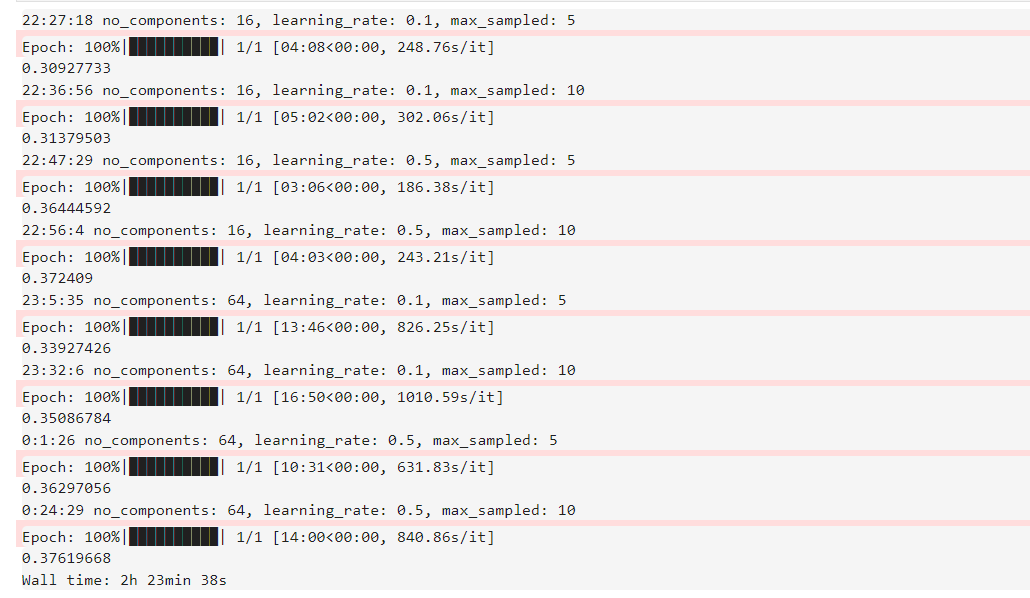

In [17]:
model3 = LightFM(no_components=64,
                    learning_rate=0.5, 
                    loss='warp',
                    max_sampled=10, random_state=23)

In [18]:
%%time
model3.fit(interactions_matrix,
          sample_weight=weights_matrix,
          item_features=item_features,
          epochs=1,
          num_threads=4,verbose=True)

Epoch: 100%|██████████| 1/1 [16:48<00:00, 1008.07s/it]

Wall time: 16min 48s


In [19]:
%%time
lightfm_ndcg_score(model3, data_train=pd.read_csv('rand_train_30.csv'),
                   data_test=pd.read_csv('rand_test_30.csv'), user_dict=user_dict,movie_dict=movie_dict,
                   percent_to_test=100, n=20)

Для 10 % пользователей mean nDcg@ =  0.31082597896972314
Для 20 % пользователей mean nDcg@ =  0.3109689389954568
Для 30 % пользователей mean nDcg@ =  0.31310612047809516
Для 40 % пользователей mean nDcg@ =  0.31267186668260555
Для 50 % пользователей mean nDcg@ =  0.31209258276909707
Для 60 % пользователей mean nDcg@ =  0.31090123750572973
Для 70 % пользователей mean nDcg@ =  0.3108288090488519
Для 80 % пользователей mean nDcg@ =  0.3116130983572778
Для 90 % пользователей mean nDcg@ =  0.31176423766385386
Для 100 % пользователей mean nDcg@ =  0.31185626048196013
Wall time: 11min 29s


0.31186953178758997

Метрика nDCG@20 при использованиии и тегов и жанров как фичей составила 0.312